In [54]:
!pip install scikit-learn==1.7.2
!pip install optuna


In [74]:
import numpy as np
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
import optuna
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
from sklearn.metrics import log_loss
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
np.set_printoptions(legacy='1.25')

# Uploading data

In [57]:
from google.colab import files

data = pd.read_pickle("Xtrain1.pkl")
Y = np.load("Ytrain1.npy")

In [58]:
data.head()

,Patient_Id,Skeleton_Features
158,8,"[0.01672805172463768, -0.5662699523188407, 0.0..."
500,12,"[0.03123780159177354, -0.5718956396, 0.0479631..."
396,6,"[0.023674554394231464, -0.5588386275217391, 0...."
155,8,"[0.009414516641025642, -0.5693782186153847, 0...."
321,3,"[0.015847331331651126, -0.5660038876666666, 0...."


In [60]:
X = np.stack(data['Skeleton_Features'])
patient_ids = data["Patient_Id"].values

print(X.shape)
print(patient_ids.shape)

(700, 132)
(700,)


# Pre processing data

---



In [61]:
# Normalizes data according to torso and shoulder length ratio
def Normalize(X):
    X_raw = X.copy()

    Avg = X_raw[:, :66]
    Std = X_raw[:, 66:]
    n = Avg.shape[0]

    Avg = Avg.reshape(n, 33, 2)
    Std = Std.reshape(n, 33, 2)

    # correct the sign of the y coordinates
    Avg[:, :, 1] *= -1

    sw = np.linalg.norm(Avg[:, 11, :] - Avg[:, 12, :], axis=1) # shoulder width
    th = np.linalg.norm(Avg[:, 0, :] - 0.5 * (Avg[:, 23, :] + Avg[:, 24, :]), axis=1) # torso height

    scale = sw / th

    Avg = Avg / scale[:, None, None]
    Std = Std / scale[:, None, None]

    Avg = Avg.reshape(n, -1)
    Std = Std.reshape(n, -1)
    return np.hstack([Avg, Std])

# Ensures all movements are represented as if performed with the positive side of the body
def Flip(X):
    X_raw = X.copy()

    Avg = X_raw[:, :66]
    Std = X_raw[:, 66:]
    n = Avg.shape[0]

    Avg = Avg.reshape(n, 33, 2)
    Std = Std.reshape(n, 33, 2)

    L = 0
    for i in range(n):
      # Condition for swapping indexes
      if np.linalg.norm(Std[i,12::2]) > np.linalg.norm(Std[i,11::2]):
        AvgSwapped = Avg[i].copy()
        AvgSwapped[2::2], AvgSwapped[1::2] = Avg[i, 1::2], Avg[i, 2::2]
        Avg[i] = AvgSwapped
        Avg[i, :, 0] *= -1

        StdSwapped = Std[i].copy()
        StdSwapped[2::2], StdSwapped[1::2] = Std[i, 1::2], Std[i, 2::2]
        Std[i] = StdSwapped
        L += 1
    Avg = Avg.reshape(n, -1)
    Std = Std.reshape(n, -1)
    return np.hstack([Avg, Std])

# Informs which side the movement was executed at
def SaySide(X):
    X_raw = X.copy()

    Avg = X_raw[:, :66]
    Std = X_raw[:, 66:]
    n = Avg.shape[0]

    Avg = Avg.reshape(n, 33, 2)
    Std = Std.reshape(n, 33, 2)

    # -1 for right-dominant, +1 for left-dominant
    Side = np.array([
        -1 if np.linalg.norm(Std[i, 12::2]) > np.linalg.norm(Std[i, 11::2]) else 1
        for i in range(n)
    ])

    return Side[:, None]

# Removes all the features from the negative side
def PositiveOnly(X):
    X_raw = X.copy()

    Avg = X_raw[:, :66]
    Std = X_raw[:, 66:]
    n = Avg.shape[0]

    Avg = Avg.reshape(n, 33, 2)
    Std = Std.reshape(n, 33, 2)

    left_indices = [4, 5, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]

    Avg = np.delete(Avg, left_indices, axis=1)
    Std = np.delete(Std, left_indices, axis=1)

    Avg = Avg.reshape(n, -1)
    Std = Std.reshape(n, -1)

    return np.hstack([Avg, Std])

# Removes the features that correspond to the leg from the negative side
def NoNegativeLeg(X):
    X_raw = X.copy()

    Avg = X_raw[:, :66]
    Std = X_raw[:, 66:]
    n = Avg.shape[0]

    Avg = Avg.reshape(n, 33, 2)
    Std = Std.reshape(n, 33, 2)

    indices = [26, 28, 30, 32]

    Avg = np.delete(Avg, indices, axis=1)
    Std = np.delete(Std, indices, axis=1)

    Avg = Avg.reshape(n, -1)
    Std = Std.reshape(n, -1)

    return np.hstack([Avg, Std])

# Visualizing data before and after processing

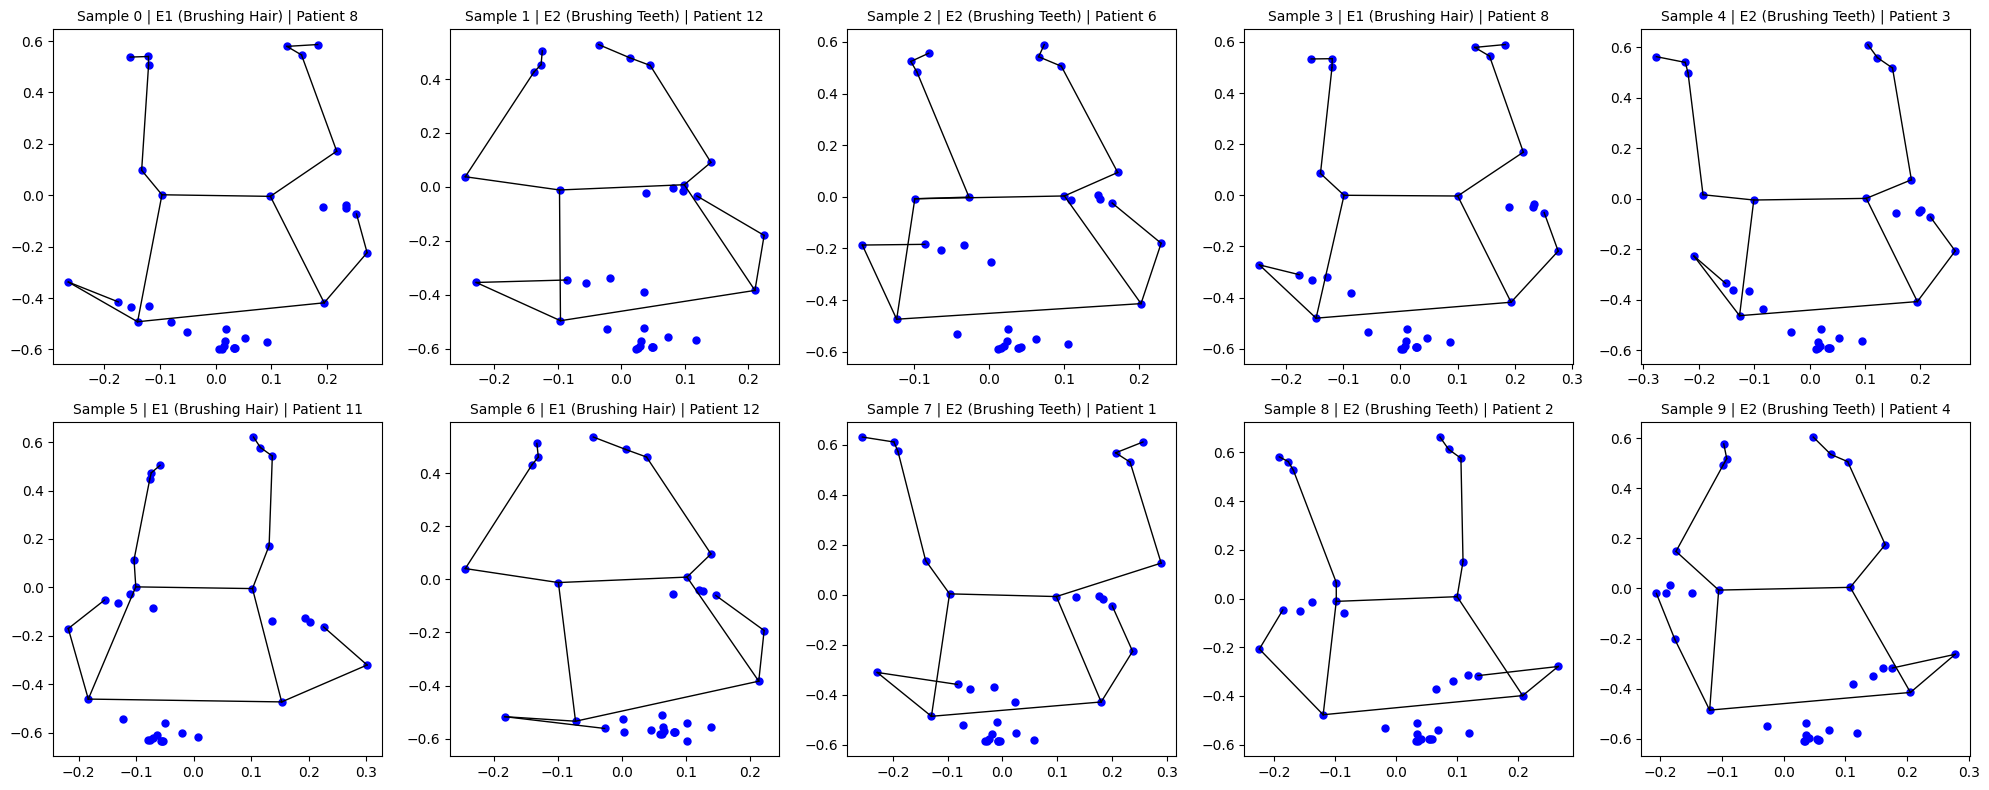

In [62]:
# Visualizing the firts 10 observations

exercises = {0: "E1 (Brushing Hair)",
             1: "E2 (Brushing Teeth)",
             2: "E5 (Hip Flexion)"}

indices = range(10)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

edges = [(11, 13), (13, 15), # left arm
         (12, 14), (14, 16), # right arm
         (11, 12),           # shoulders
         (23, 24),           # hips
         (11, 23), (12, 24), # torso
         (23, 25), (25, 27), # left leg
         (24, 26), (26, 28), # right leg
         (27, 29), (29, 31), # left foot
         (28, 30), (30, 32)] # right foot

for ax, idx in zip(axes, indices):
    coords = X[idx, :66].reshape(33, 2)
    x, y = coords[:, 0], coords[:, 1]

    ax.scatter(x, y, s=25, c='blue')

    for (i, j) in edges:
        ax.plot([x[i], x[j]], [y[i], y[j]], 'k-', lw=1)

    label = Y[idx]
    patient = patient_ids[idx]
    ax.set_title(f"Sample {idx} | {exercises[label]} | Patient {patient}", fontsize=10)

plt.tight_layout()
plt.show()


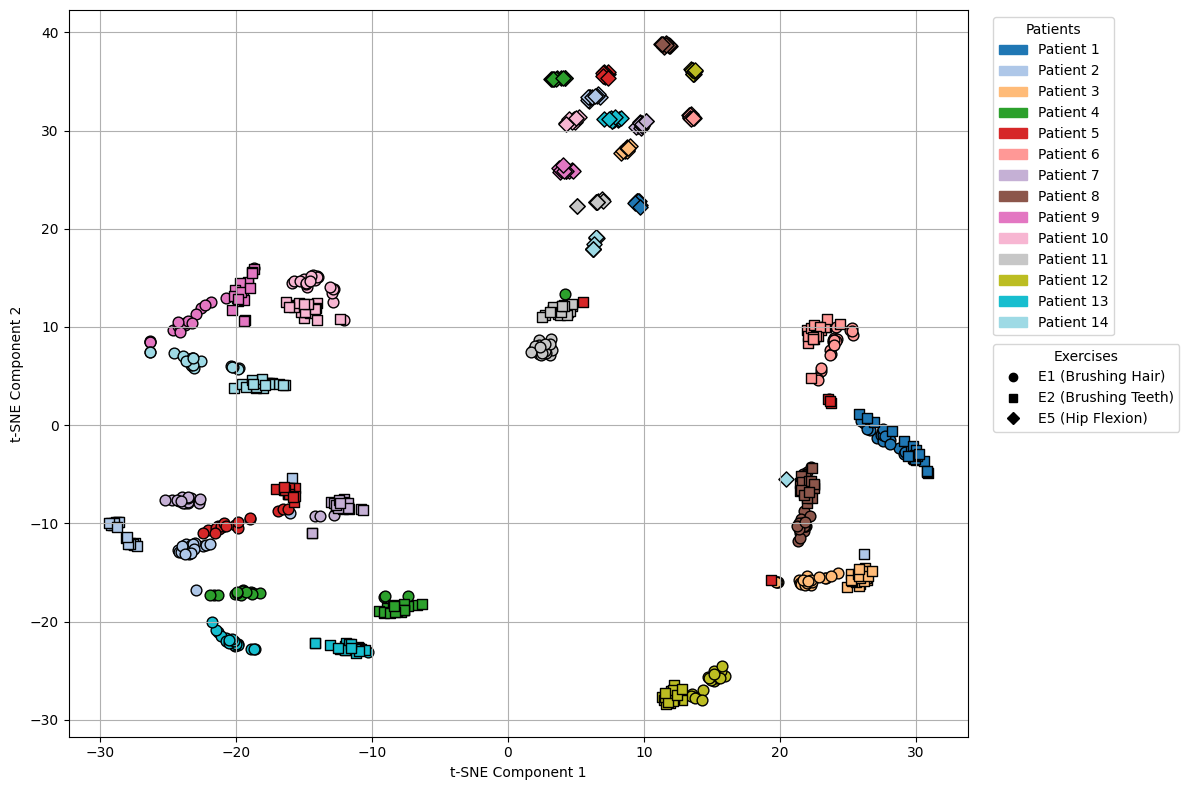

In [63]:
# Visualizing relations between the data using t-SNE reduction
x_embedded = TSNE(n_components=2, random_state=42).fit_transform(X)

markers = {0: "o", 1: "s", 2: "D"}
exercises = {0: "E1 (Brushing Hair)",
             1: "E2 (Brushing Teeth)",
             2: "E5 (Hip Flexion)"}

patients = np.unique(patient_ids)
colors = plt.cm.tab20(np.linspace(0, 1, len(patients)))
patient_color_map = {pid: color for pid, color in zip(patients, colors)}

plt.figure(figsize=(12, 8))

# Plot
for exercise_label in np.unique(Y):
    idx = np.where(Y == exercise_label)[0]
    for pid in patients:
        pid_idx = idx[patient_ids[idx] == pid]
        if len(pid_idx) == 0:
            continue
        plt.scatter(x_embedded[pid_idx, 0],
                    x_embedded[pid_idx, 1],
                    color=patient_color_map[pid],
                    marker=markers[exercise_label],
                    s=60,
                    edgecolors="k")

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)

# Legend
patient_patches = [mpatches.Patch(color=patient_color_map[pid], label=f"Patient {pid}")
                   for pid in patients]
legend1 = plt.legend(handles=patient_patches, title="Patients",
                     loc='upper left', bbox_to_anchor=(1.02, 1))

exercise_patches = [plt.Line2D([0], [0], marker=markers[ex], color='k', label=exercises[ex], linestyle='')
                    for ex in markers]
legend2 = plt.legend(handles=exercise_patches, title="Exercises",
                     loc='upper left', bbox_to_anchor=(1.02, 0.55))

plt.gca().add_artist(legend1)
plt.tight_layout()
plt.show()


In [64]:
# Patient we want to remove
patient = 1
keep_idx = np.where(patient_ids != patient)[0]

# Filter the datasets
X_without_patient = X[keep_idx]
Y_without_patient = Y[keep_idx]
patient_without_patient = patient_ids[keep_idx]

print(f"Original dataset shape: {X.shape}")
print(f"Filtered dataset shape: {X_without_patient.shape}")


Original dataset shape: (700, 132)
Filtered dataset shape: (650, 132)


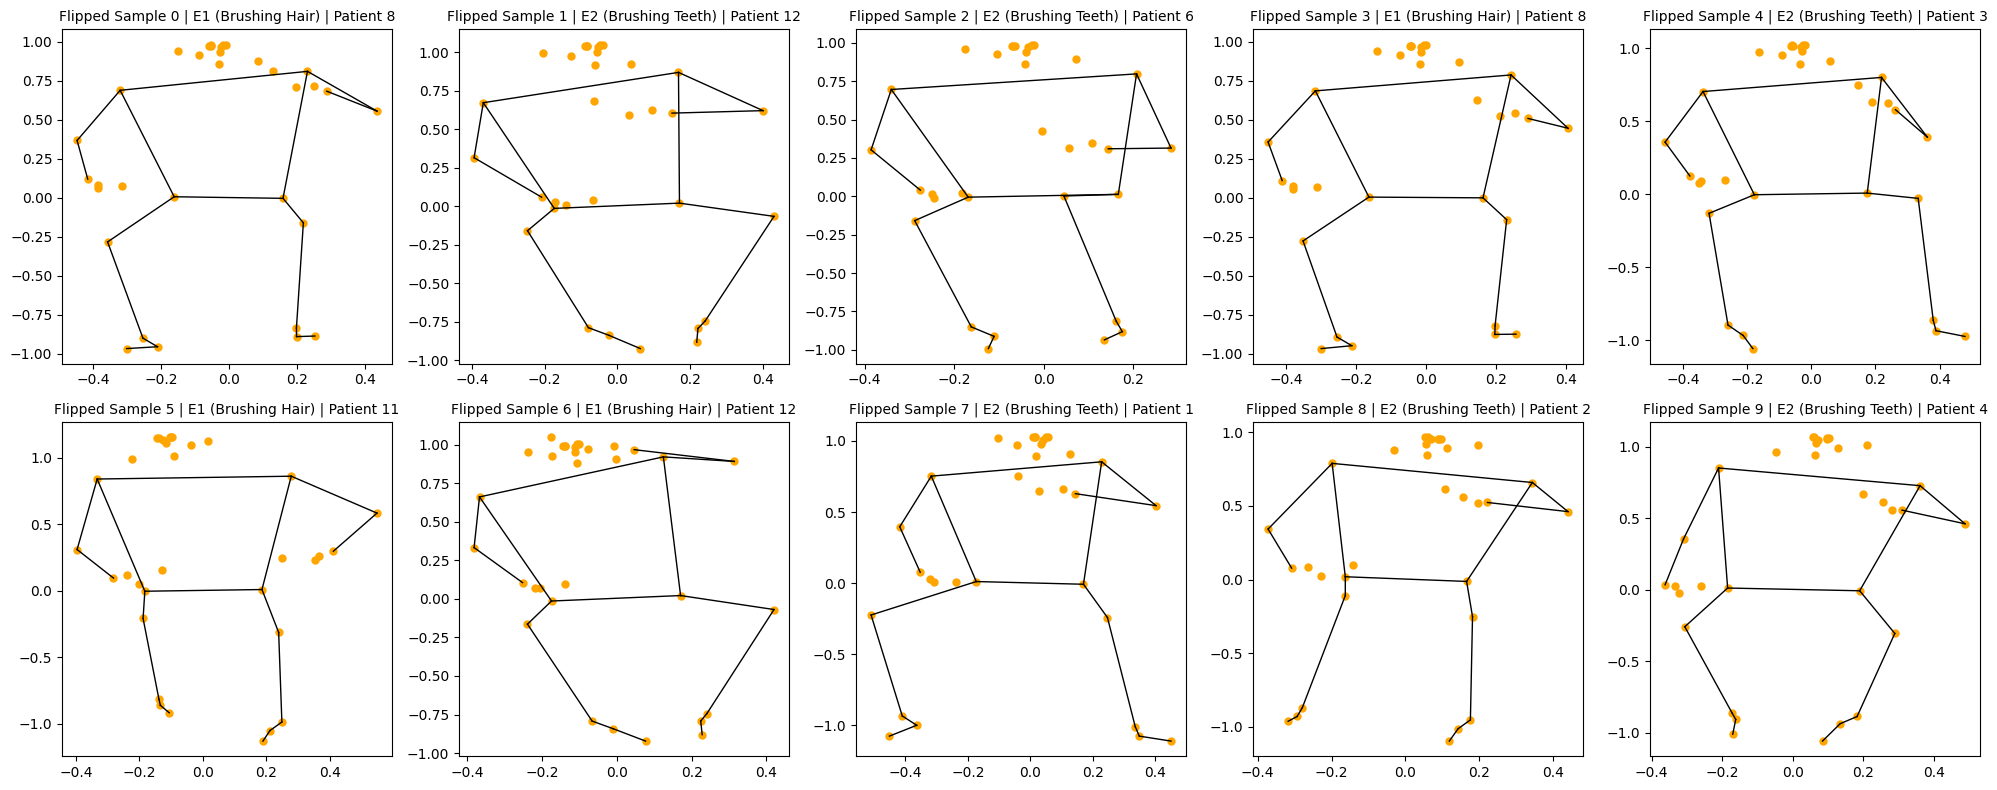

In [65]:
# Visualizing data after flipping and normalizing it
exercises = {0: "E1 (Brushing Hair)",
             1: "E2 (Brushing Teeth)",
             2: "E5 (Hip Flexion)"}

X_processed = Flip(Normalize(X.copy()))

indices = range(10)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

edges = [(11, 13), (13, 15), # left arm
         (12, 14), (14, 16), # right arm
         (11, 12),           # shoulders
         (23, 24),           # hips
         (11, 23), (12, 24), # torso
         (23, 25), (25, 27), # left leg
         (24, 26), (26, 28), # right leg
         (27, 29), (29, 31), # left foot
         (28, 30), (30, 32)] # right foot


for ax, idx in zip(axes, indices):
    coords = X_processed[idx, :66].reshape(33, 2)
    x, y = coords[:, 0], coords[:, 1]

    ax.scatter(x, y, s=25, c='orange')

    for (i, j) in edges:
        ax.plot([x[i], x[j]], [y[i], y[j]], 'k-', lw=1)

    label = Y[idx]
    patient = patient_ids[idx]
    ax.set_title(f"Flipped Sample {idx} | {exercises[label]} | Patient {patient}", fontsize=10)

plt.tight_layout()
plt.show()


# Adding features

In [66]:
NOSE = 0
MOUTH_L, MOUTH_R = 10, 9
LS, RS = 12, 11
LE, RE = 14, 13
LW, RW = 16, 15
LHIP, RHIP = 24, 23
LK, RK = 26, 25
LA, RA = 28, 27

def AvgStd(X):
    n = X.shape[0]
    avg = X[:, :66].reshape(n, 33, 2)
    std = X[:, 66:].reshape(n, 33, 2)
    return avg, std

def Distance(a, b):
    return np.linalg.norm(a - b, axis=-1)

def AngleAtb(a, b, c):
    # Angle at b formed by points a-b-c
    ba = a - b
    bc = c - b
    dot = np.sum(ba * bc, axis=-1)
    denom = np.linalg.norm(ba, axis=-1) * np.linalg.norm(bc, axis=-1)
    denom = np.where(denom == 0, 1e-8, denom)
    cos = np.clip(dot / denom, -1.0, 1.0)
    return np.arccos(cos)

# Define the features we intend to add
def FeatureComp(X):
    avg, std = AvgStd(X)
    n = X.shape[0]

    nose = avg[:, NOSE, :]
    mouthc = 0.5 * (avg[:, MOUTH_L, :] + avg[:, MOUTH_R, :])
    lw = avg[:, LW, :]
    rw = avg[:, RW, :]
    ls = avg[:, LS, :]
    rs = avg[:, RS, :]
    le = avg[:, LE, :]
    re = avg[:, RE, :]
    lhip = avg[:, LHIP, :]
    rhip = avg[:, RHIP, :]
    lk = avg[:, LK, :]
    rk = avg[:, RK, :]
    la = avg[:, LA, :]
    ra = avg[:, RA, :]

    # wrist to mouth distance
    feat1_p = Distance(rw, mouthc)
    feat1_n = Distance(lw, mouthc)

    # elbow angle
    feat2_p = AngleAtb(rs, re, rw)
    feat2_n = AngleAtb(ls, le, lw)

    # right knee angle
    feat3 = AngleAtb(rhip, rk, ra)

    # torso and elbow angle
    feat4_p = AngleAtb(rhip, rs, re)
    feat4_n = AngleAtb(lhip, ls, le)

    # wrist to hip distance
    feat5_p = Distance(rw, rhip)
    feat5_n = Distance(lw, lhip)

    feats = np.stack([feat1_p, feat1_n,
                      feat2_p, feat2_n,
                      feat3,
                      feat4_p, feat4_n,
                      feat5_p, feat5_n], axis=1)

    return feats

ExtraFeatures = FeatureComp(Flip(Normalize(X)))
print(ExtraFeatures[0:10])


[[0.40166674 0.84613255 0.18180725 2.63920685 2.74607692 0.76615057
  0.60573006 0.69852506 0.27867679]
 [0.41891734 0.89262607 0.88257229 2.44392569 1.6182284  0.74934137
  0.3477084  0.58454346 0.08033477]
 [0.62374376 0.87765867 1.44556022 2.63078329 1.5178805  0.209717
  0.35430385 0.29791268 0.1165226 ]
 [0.50682457 0.85739817 0.62354169 2.58928523 2.64254226 0.54591295
  0.61167857 0.52481905 0.26961792]
 [0.47434538 0.85894615 0.15022169 2.49172161 1.85160742 0.39174039
  0.55089752 0.5782883  0.23832346]
 [0.89422973 0.98310836 1.92040079 2.53079292 2.99491505 0.88100313
  0.29541656 0.36522262 0.13985475]
 [0.19759825 0.80602877 0.12337862 2.57884918 1.65879178 1.36533709
  0.32200712 0.95391288 0.14215541]
 [0.34191753 0.92035993 0.74065444 2.66338747 2.94030126 0.58145442
  0.46777131 0.63748294 0.19105404]
 [0.37328491 0.88550738 0.83908235 2.53506528 3.06654222 0.71292575
  0.41695268 0.53919456 0.15655693]
 [0.46213095 1.03897135 0.63348708 3.10608947 2.63866227 0.6735947

# Training and comparing different models
- Random Forest
- Logistic Regression
- Support Vector Machine - SVC with RBF Kernel
- Neural Networks - Multilayer Perceptron


In [68]:
#Checking if classes are balanced
zeros = 0
ones = 0
twos = 0
for i in Y:
  if i == 0:
    zeros += 1
  elif i == 1:
    ones += 1
  else:
    twos += 1
print(zeros)
print(ones)
print(twos)

280
280
140


In [72]:
# Testing if splitting is being done according to patient ids
gkf = GroupKFold(n_splits=7)
for fold, (train_idx, val_idx) in enumerate(gkf.split(X, Y, groups=patient_ids)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = Y[train_idx], Y[val_idx]

    train_patients = np.unique(patient_ids[train_idx])
    val_patients = np.unique(patient_ids[val_idx])

    print(f"Fold {fold+1}")
    print("Train patients:", train_patients)
    print("Val patients:", val_patients)

Fold 1
Train patients: [ 1  2  3  4  5  6  8  9 10 11 12 13]
Val patients: [ 7 14]
Fold 2
Train patients: [ 1  2  3  4  5  7  8  9 10 11 12 14]
Val patients: [ 6 13]
Fold 3
Train patients: [ 1  2  3  4  6  7  8  9 10 11 13 14]
Val patients: [ 5 12]
Fold 4
Train patients: [ 1  2  3  5  6  7  8  9 10 12 13 14]
Val patients: [ 4 11]
Fold 5
Train patients: [ 1  2  4  5  6  7  8  9 11 12 13 14]
Val patients: [ 3 10]
Fold 6
Train patients: [ 1  3  4  5  6  7  8 10 11 12 13 14]
Val patients: [2 9]
Fold 7
Train patients: [ 2  3  4  5  6  7  9 10 11 12 13 14]
Val patients: [1 8]


In [ ]:
# Finding best hyperparamaters for Random Forest

gkf = GroupKFold(n_splits=7)

X_normalize = Normalize(X.copy())

def objective(trial):
    # Hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500)

    model = RandomForestClassifier(n_estimators=200, random_state=42)

    f1s = []

    # Cross-validation
    for train_idx, val_idx in gkf.split(X_normalize, Y, groups=patient_ids):
        X_train, X_val = X_normalize[train_idx], X_normalize[val_idx]
        y_train, y_val = Y[train_idx], Y[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        f1s.append(f1_score(y_val, y_pred, average="macro"))

    return np.mean(f1s)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print(f"F1-Score: {trial.value:.3f}")
print(f"Params: {trial.params}")

[I 2025-10-11 13:29:42,035] A new study created in memory with name: no-name-83d7b174-d92a-4f79-a2ee-97dd17550247
[I 2025-10-11 13:29:51,863] Trial 0 finished with value: 0.820618607726274 and parameters: {'n_estimators': 410}. Best is trial 0 with value: 0.820618607726274.
[I 2025-10-11 13:30:01,014] Trial 1 finished with value: 0.820618607726274 and parameters: {'n_estimators': 390}. Best is trial 0 with value: 0.820618607726274.
[I 2025-10-11 13:30:10,904] Trial 2 finished with value: 0.820618607726274 and parameters: {'n_estimators': 117}. Best is trial 0 with value: 0.820618607726274.
[I 2025-10-11 13:30:20,850] Trial 3 finished with value: 0.820618607726274 and parameters: {'n_estimators': 360}. Best is trial 0 with value: 0.820618607726274.
[I 2025-10-11 13:30:30,757] Trial 4 finished with value: 0.820618607726274 and parameters: {'n_estimators': 209}. Best is trial 0 with value: 0.820618607726274.
[I 2025-10-11 13:30:40,144] Trial 5 finished with value: 0.820618607726274 and pa

Best trial:
F1-Score: 0.821
Params: {'n_estimators': 410}


Fold 1: acc=0.780, f1=0.800
Confusion matrix
[[19 21  0]
 [ 0 40  0]
 [ 1  0 19]]


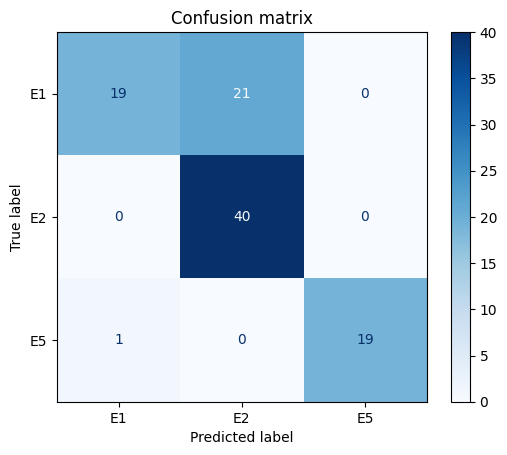

Fold 2: acc=0.840, f1=0.867
Confusion matrix
[[32  8  0]
 [ 8 32  0]
 [ 0  0 20]]


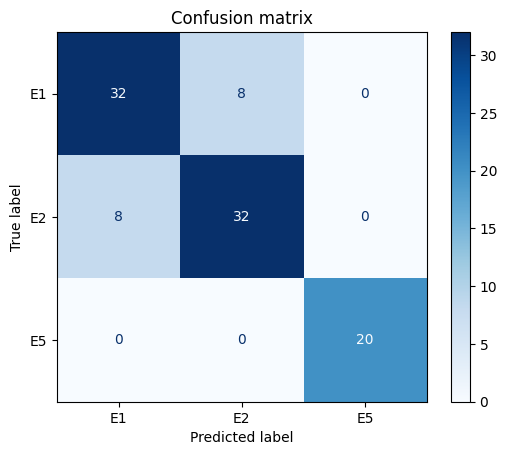

Fold 3: acc=0.780, f1=0.809
Confusion matrix
[[21 19  0]
 [ 3 37  0]
 [ 0  0 20]]


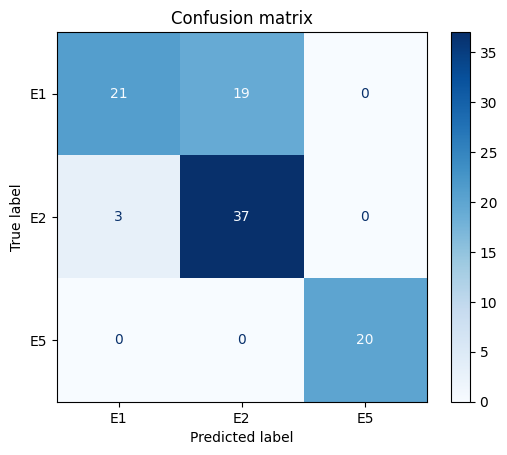

Fold 4: acc=0.830, f1=0.852
Confusion matrix
[[40  0  0]
 [17 23  0]
 [ 0  0 20]]


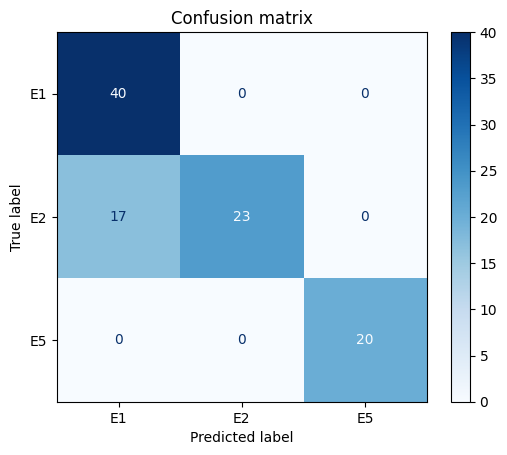

Fold 5: acc=0.900, f1=0.916
Confusion matrix
[[32  8  0]
 [ 2 38  0]
 [ 0  0 20]]


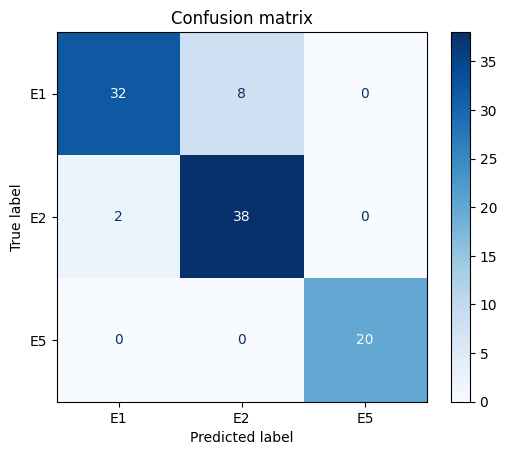

Fold 6: acc=0.820, f1=0.847
Confusion matrix
[[37  3  0]
 [15 25  0]
 [ 0  0 20]]


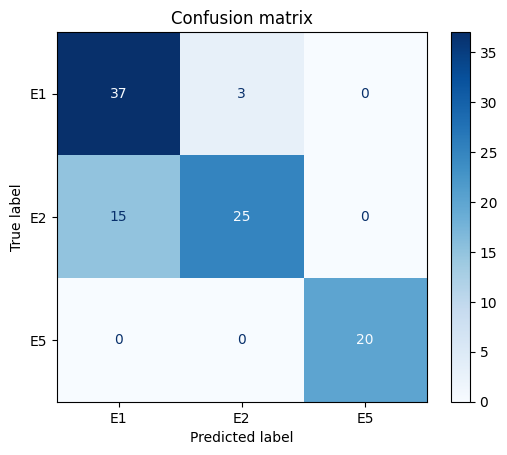

Fold 7: acc=0.650, f1=0.664
Confusion matrix
[[ 8 32  0]
 [ 3 37  0]
 [ 0  0 20]]


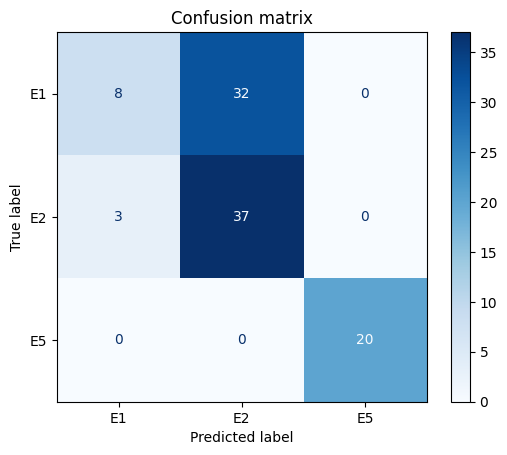

Mean Accuracy: 0.800
Mean Macro-F1: 0.822


In [ ]:
# Random Forest

gkf = GroupKFold(n_splits=7)

X_normalize = Normalize(X.copy())

accs, f1s = [], []
model = RandomForestClassifier(n_estimators=410, random_state=42)

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_normalize, Y, groups=patient_ids)):
        X_train, X_val = X_normalize[train_idx], X_normalize[val_idx]
        y_train, y_val = Y[train_idx], Y[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        accs.append(accuracy_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred, average="macro"))

        print(f"Fold {fold+1}: acc={accs[-1]:.3f}, f1={f1s[-1]:.3f}")

        # Plot confusion matrix
        class_names = ["E1", "E2", "E5"]
        titles_options = [("Confusion matrix", None)]
        for title, normalize in titles_options:
            disp = ConfusionMatrixDisplay.from_estimator(model,
                                                         X_val,
                                                         y_val,
                                                         display_labels=class_names,
                                                         cmap=plt.cm.Blues)
            disp.ax_.set_title(title)

            print(title)
            print(disp.confusion_matrix)

        plt.show()

print(f"Mean Accuracy: {np.mean(accs):.3f}")
print(f"Mean Macro-F1: {np.mean(f1s):.3f}")

In [73]:
# Finding best hyperparamaters for Logistic Regression

gkf = GroupKFold(n_splits=5)

def objective(trial):
    # hyperparameters
    C = trial.suggest_float('C', 1e-3, 1e2, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'

    model = LogisticRegression(C=C,
                               penalty=penalty,
                               solver=solver,
                               max_iter=500,
                               class_weight='balanced',
                               random_state=42)

    f1s = []
    # Cross-validation
    for train_idx, val_idx in gkf.split(X, Y, groups=patient_ids):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = Y[train_idx], Y[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        f1s.append(f1_score(y_val, y_pred, average="macro"))

    return np.mean(f1s)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=90)

print("Best trial:")
trial = study.best_trial
print(f"F1-Score: {trial.value:.3f}")
print(f"Params: {trial.params}")

[I 2025-10-11 17:04:19,061] A new study created in memory with name: no-name-5cacb566-a219-4361-859b-8ad426a1cec9
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classif

KeyboardInterrupt: 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Fold 1: acc=0.753, f1=0.776
Confusion matrix
[[34 26  0]
 [ 6 54  0]
 [ 5  0 25]]


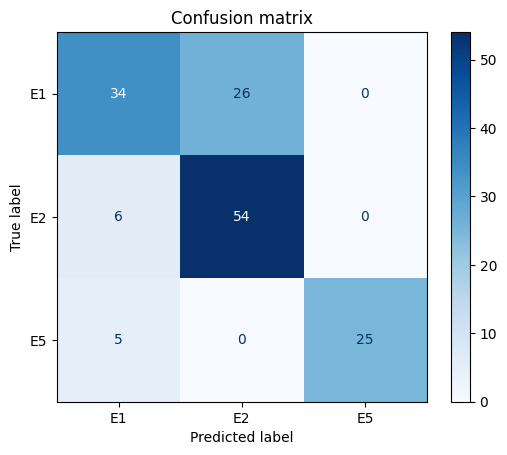

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Fold 2: acc=0.907, f1=0.922
Confusion matrix
[[58  2  0]
 [12 48  0]
 [ 0  0 30]]


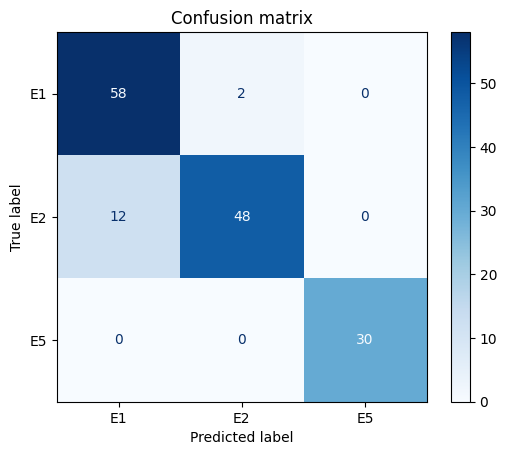

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Fold 3: acc=0.787, f1=0.821
Confusion matrix
[[39 21  0]
 [11 49  0]
 [ 0  0 30]]


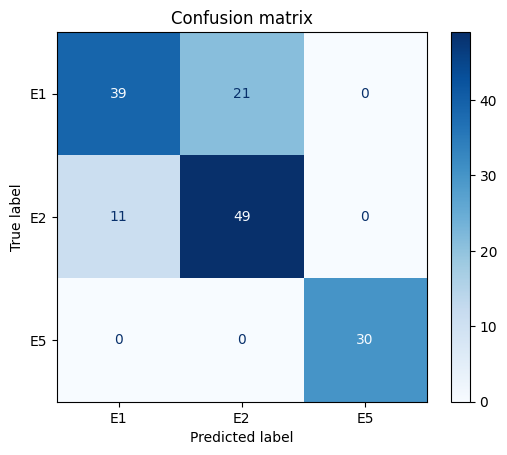

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Fold 4: acc=0.747, f1=0.764
Confusion matrix
[[24 35  1]
 [ 1 58  1]
 [ 0  0 30]]


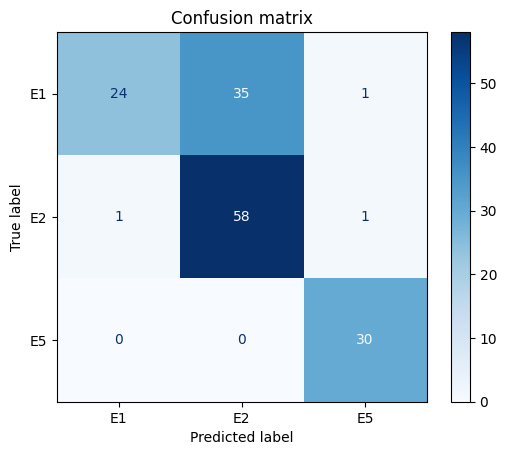

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Fold 5: acc=0.970, f1=0.975
Confusion matrix
[[38  2  0]
 [ 1 39  0]
 [ 0  0 20]]


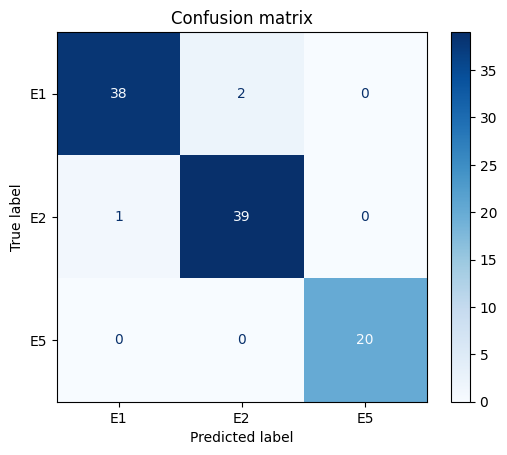

Mean Accuracy: 0.833
Mean Macro-F1: 0.851


In [70]:
# Logistic Regression

gkf = GroupKFold(n_splits=5)

accs, f1s = [], []
model = LogisticRegression(C = 18.443315415639457,
                           penalty = 'l1',
                           solver  = 'liblinear',
                           max_iter = 500,
                           class_weight = 'balanced',
                           random_state = 42)

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, Y, groups=patient_ids)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = Y[train_idx], Y[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        accs.append(accuracy_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred, average="macro"))

        print(f"Fold {fold+1}: acc={accs[-1]:.3f}, f1={f1s[-1]:.3f}")

        # Plot confusion matrix
        class_names = ["E1", "E2", "E5"]
        titles_options = [("Confusion matrix", None)]
        for title, normalize in titles_options:
            disp = ConfusionMatrixDisplay.from_estimator(model,
                                                         X_val,
                                                         y_val,
                                                         display_labels=class_names,
                                                         cmap=plt.cm.Blues)
            disp.ax_.set_title(title)

            print(title)
            print(disp.confusion_matrix)

        plt.show()

print(f"Mean Accuracy: {np.mean(accs):.3f}")
print(f"Mean Macro-F1: {np.mean(f1s):.3f}")

In [ ]:
# Finding best hyperparameters for SVM with RBF Kernel

gkf = GroupKFold(n_splits=7)
X_normalize = np.hstack([Flip(Normalize(X.copy())), SaySide(X)])

def objective(trial):
    # Suggest hyperparameters
    C = trial.suggest_float('C', 1e-3, 1e2, log=True)
    gamma_choice = trial.suggest_categorical('gamma_choice', ['scale', 'auto', 'float'])
    if gamma_choice == 'float':
        gamma = trial.suggest_float('gamma', 1e-6, 1e1, log=True)
    else:
        gamma = gamma_choice

    # Initialize model
    model = svm.SVC(kernel = 'rbf',
                    C = C,
                    gamma = gamma,
                    random_state = 42)

    f1s = []
    # Cross-validation
    for train_idx, val_idx in gkf.split(X_normalize, Y, groups=patient_ids):
        X_train, X_val = X_normalize[train_idx], X_normalize[val_idx]
        y_train, y_val = Y[train_idx], Y[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        f1s.append(f1_score(y_val, y_pred, average="macro"))

    return np.mean(f1s)

study = optuna.create_study(direction="maximize", study_name="SVM_RBF_tuning_f1", storage="sqlite:///optuna_study.db", load_if_exists=True)
study.optimize(objective, n_trials=200)

print("Best trial:")
trial = study.best_trial
print(f"F1-Score: {trial.value:.3f}")
print(f"Params: {trial.params}")



[I 2025-10-11 16:34:55,875] Using an existing study with name 'SVM_RBF_tuning_f1' instead of creating a new one.
[I 2025-10-11 16:34:56,400] Trial 600 finished with value: 0.8921856407845522 and parameters: {'C': 37.75222971449283, 'gamma_choice': 'float', 'gamma': 0.5274594249165814}. Best is trial 303 with value: 0.9170296399544269.
[I 2025-10-11 16:34:56,721] Trial 601 finished with value: 0.8713206202553019 and parameters: {'C': 14.615255704475697, 'gamma_choice': 'float', 'gamma': 0.1301498879633977}. Best is trial 303 with value: 0.9170296399544269.
[I 2025-10-11 16:34:57,003] Trial 602 finished with value: 0.9077106524416004 and parameters: {'C': 29.646326710808015, 'gamma_choice': 'float', 'gamma': 0.18668973220724103}. Best is trial 303 with value: 0.9170296399544269.
[I 2025-10-11 16:34:57,310] Trial 603 finished with value: 0.9123637844889478 and parameters: {'C': 23.264801563478972, 'gamma_choice': 'float', 'gamma': 0.379989011154101}. Best is trial 303 with value: 0.917029

Best trial:
F1-Score: 0.917
Params: {'C': 21.43065912166217, 'gamma_choice': 'float', 'gamma': 0.2700490541006654}


Confusion matrix, without normalization
[[38  2  0]
 [ 0 40  0]
 [ 0  1 19]]


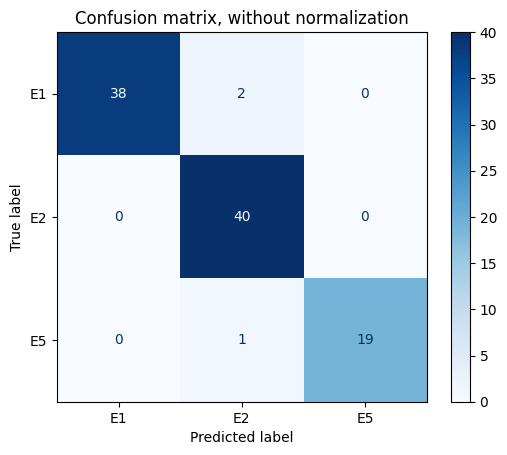

Fold 1: acc=0.970, f1=0.971
Confusion matrix, without normalization
[[35  5  0]
 [ 1 39  0]
 [ 0  0 20]]


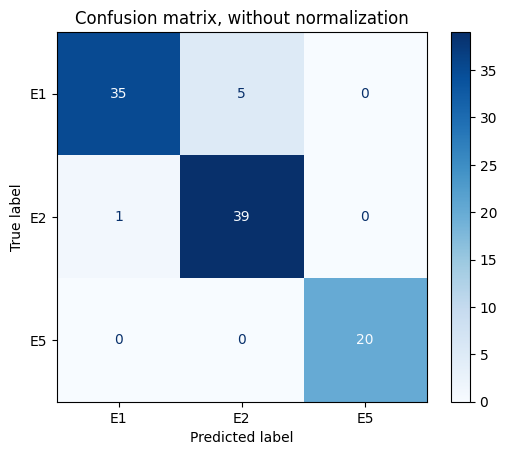

Fold 2: acc=0.940, f1=0.950
Confusion matrix, without normalization
[[36  4  0]
 [ 2 38  0]
 [ 0  0 20]]


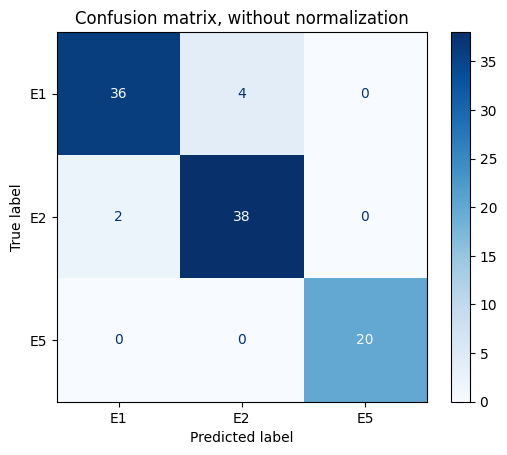

Fold 3: acc=0.940, f1=0.950
Confusion matrix, without normalization
[[40  0  0]
 [ 1 39  0]
 [ 0  0 20]]


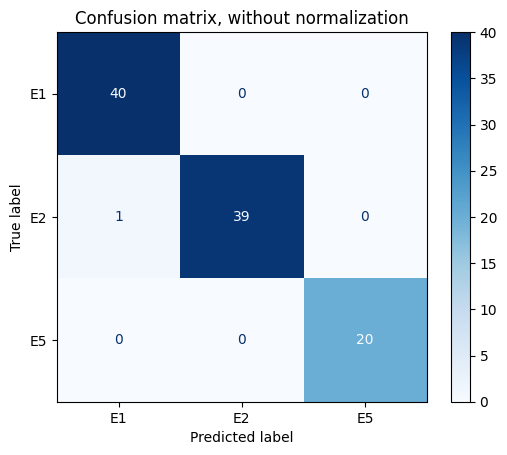

Fold 4: acc=0.990, f1=0.992
Confusion matrix, without normalization
[[36  4  0]
 [15 25  0]
 [ 0  0 20]]


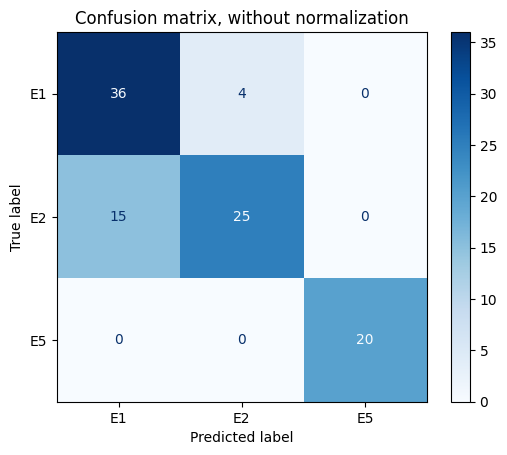

Fold 5: acc=0.810, f1=0.839
Confusion matrix, without normalization
[[40  0  0]
 [13 27  0]
 [ 0  0 20]]


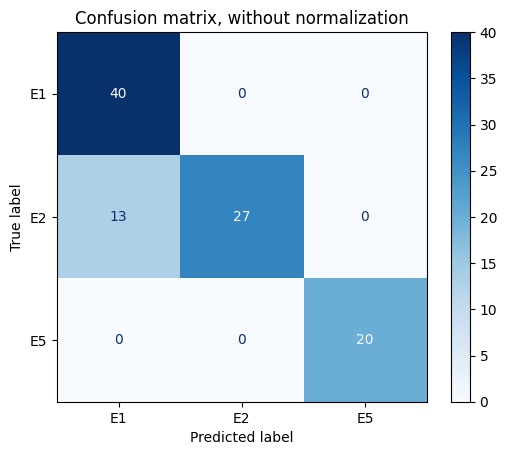

Fold 6: acc=0.870, f1=0.889
Confusion matrix, without normalization
[[36  4  0]
 [16 24  0]
 [ 0  0 20]]


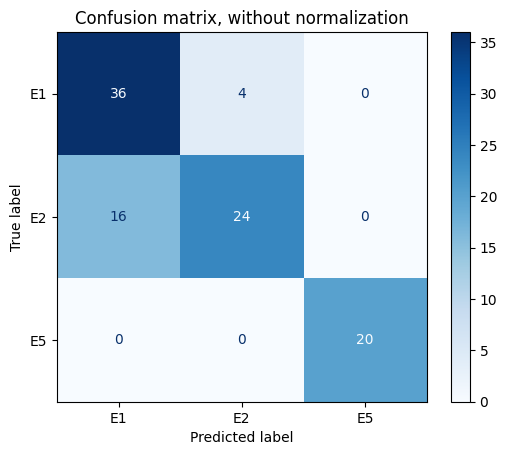

Fold 7: acc=0.800, f1=0.829
Mean Accuracy: 0.903
Mean Macro-F1: 0.917


In [ ]:
# SVM with RBF Kernel

gkf = GroupKFold(n_splits=7)

accs, f1s = [], []
model = svm.SVC(kernel = 'rbf',
                C = 21.40224063941288,
                gamma = 0.2701466685143745,
                random_state = 42)

X_normalize = np.hstack([Flip(Normalize(X.copy())), SaySide(X)])

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_normalize, Y, groups=patient_ids)):
        X_train, X_val = X_normalize[train_idx], X_normalize[val_idx]
        y_train, y_val = Y[train_idx], Y[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        accs.append(accuracy_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred, average="macro"))

        # Plot non-normalized confusion matrix
        class_names = ["E1", "E2", "E5"]
        titles_options = [("Confusion matrix", None)]
        for title, normalize in titles_options:
            disp = ConfusionMatrixDisplay.from_estimator(model,
                                                         X_val,
                                                         y_val,
                                                         display_labels=class_names,
                                                         cmap=plt.cm.Blues)
            disp.ax_.set_title(title)

            print(title)
            print(disp.confusion_matrix)

        plt.show()

        print(f"Fold {fold+1}: acc={accs[-1]:.3f}, f1={f1s[-1]:.3f}")

print(f"Mean Accuracy: {np.mean(accs):.3f}")
print(f"Mean Macro-F1: {np.mean(f1s):.3f}")

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.12/dist-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/optuna/trial/_trial.py:501: UserWarning: The reporte

Best macro-F1: 0.9050
Best hyperparameters: {'hidden_layer_size': 245, 'alpha': 0.00030656526153644204, 'learning_rate_init': 0.003563629927596543, 'batch_size': 32}


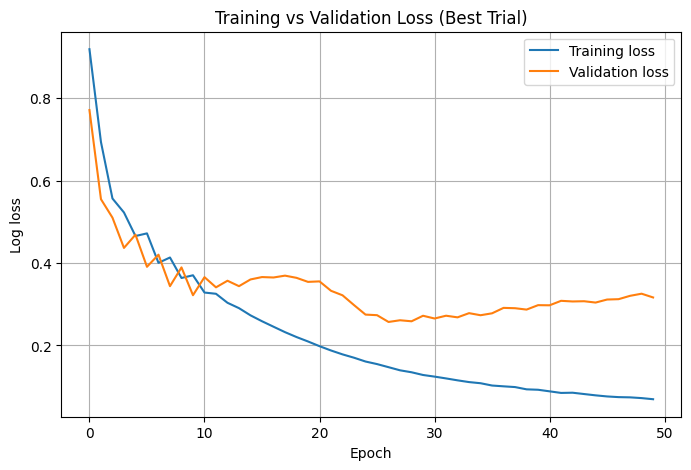

In [ ]:
# Best hyperparameter MLP

gkf = GroupKFold(n_splits=5)

def objective(trial):
    # hyperparameters
    hidden_size = trial.suggest_int("hidden_layer_size", 64, 256)
    alpha = trial.suggest_loguniform("alpha", 1e-5, 1e-2)
    lr_init = trial.suggest_loguniform("learning_rate_init", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    n_epochs = 50
    fold_f1_scores = []
    fold_train_losses = []
    fold_val_losses = []

    # Cross-validation
    for fold, (train_idx, val_idx) in enumerate(gkf.split(X, Y, groups=patient_ids)):
        #scaler = StandardScaler()
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = Y[train_idx], Y[val_idx]
        #scaler.fit(X_train)
        #X_train = scaler.transform(X_train)
        #X_val = scaler.transform(X_val)

        clf = MLPClassifier(hidden_layer_sizes=(hidden_size,),
                            activation="relu",
                            solver="adam",
                            alpha=alpha,
                            learning_rate_init=lr_init,
                            batch_size=batch_size,
                            max_iter=1,         # one epoch at a time
                            warm_start=True,
                            random_state=42)

        train_losses, val_losses, val_f1s = [], [], []

        for epoch in range(n_epochs):
            clf.fit(X_train, y_train)

            # Training loss
            train_loss = clf.loss_

            # Validation metrics
            val_probs = clf.predict_proba(X_val)
            val_loss = log_loss(y_val, val_probs)
            val_preds = np.argmax(val_probs, axis=1)
            val_f1 = f1_score(y_val, val_preds, average="macro")

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_f1s.append(val_f1)

            trial.report(np.mean(val_f1s[-3:]), epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

        # Store average F1 across all epochs for this fold
        fold_f1_scores.append(max(val_f1s))
        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)

    # Mean validation F1 across all folds
    mean_f1 = np.mean(fold_f1_scores)

    # Save curves (for the best fold) for visualization
    trial.set_user_attr("train_losses", fold_train_losses[0])
    trial.set_user_attr("val_losses", fold_val_losses[0])

    return mean_f1

study = optuna.create_study(direction="maximize", study_name="MLP_tuning", storage="sqlite:///optuna_study_MLP.db", load_if_exists=True)
#study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# best trial
best_trial = study.best_trial
print(f"Best macro-F1: {best_trial.value:.4f}")
print(f"Best hyperparameters: {best_trial.params}")

train_losses = best_trial.user_attrs["train_losses"]
val_losses = best_trial.user_attrs["val_losses"]

# Plot training vs validation loss for best trial
plt.figure(figsize=(8,5))
plt.plot(train_losses, label = "Training loss")
plt.plot(val_losses, label = "Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.title("Training vs Validation Loss (Best Trial)")
plt.legend()
plt.grid(True)
plt.show()


Confusion matrix
[[39 21  0]
 [ 1 59  0]
 [ 0  1 29]]


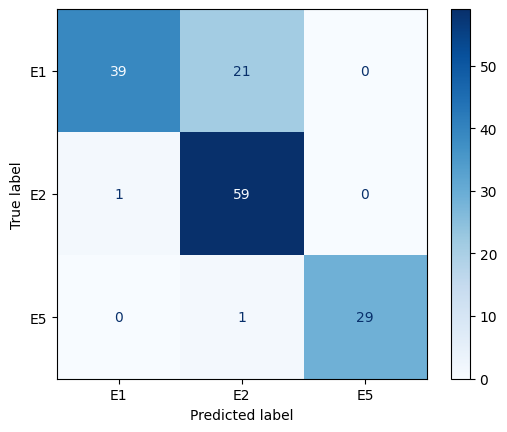

Fold 1: acc=0.847, f1=0.867
Fold 2: early stopping at epoch 10
Confusion matrix
[[58  2  0]
 [40 20  0]
 [ 0  0 30]]


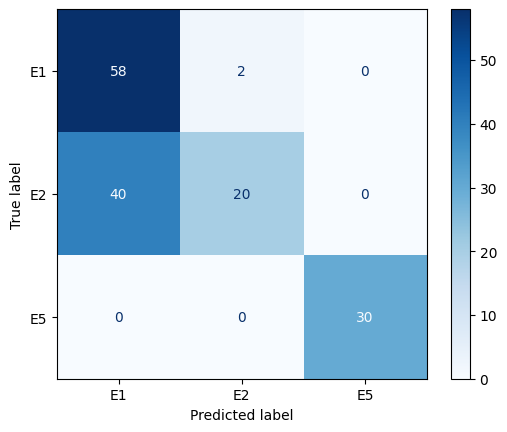

Fold 2: acc=0.720, f1=0.741
Confusion matrix
[[47 13  0]
 [ 1 59  0]
 [ 0  0 30]]


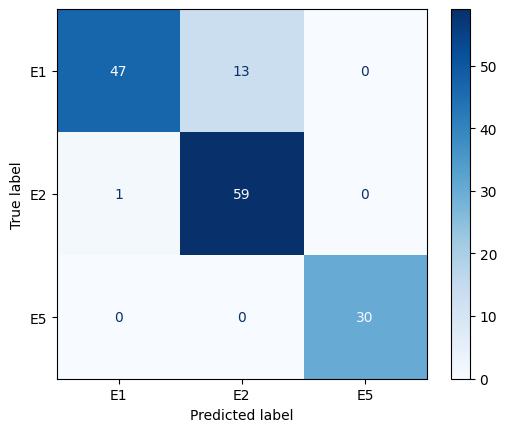

Fold 3: acc=0.907, f1=0.921
Fold 4: early stopping at epoch 6
Confusion matrix
[[ 1 55  4]
 [ 1 56  3]
 [ 0  0 30]]


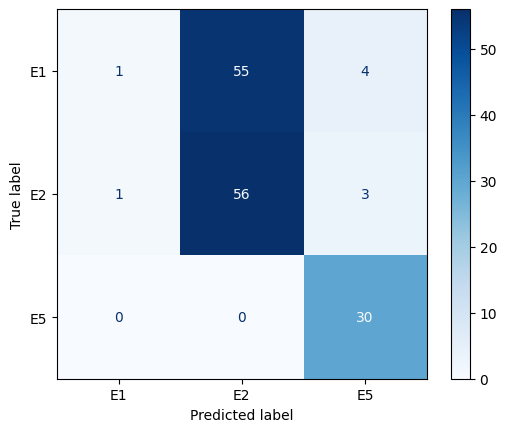

Fold 4: acc=0.580, f1=0.528
Confusion matrix
[[38  2  0]
 [ 0 40  0]
 [ 0  0 20]]


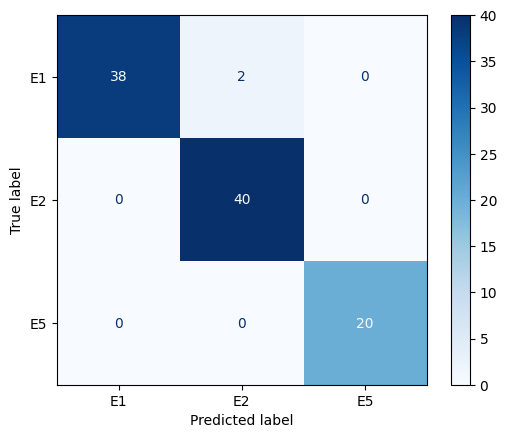

Fold 5: acc=0.980, f1=0.983
Mean Accuracy: 0.807
Mean Macro-F1: 0.824


In [82]:
# MLP

accs, f1s = [], []
gkf = GroupKFold(n_splits=5)

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, Y, groups=patient_ids)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = Y[train_idx], Y[val_idx]

    model = MLPClassifier(hidden_layer_sizes=(245,),
                          activation="relu",
                          solver="adam",
                          alpha=0.00030656526153644204,
                          learning_rate_init=0.003563629927596543,
                          batch_size=32,
                          max_iter=1,
                          warm_start=True,
                          random_state=42)

    n_epochs = 11
    best_loss = np.inf
    no_improve = 0
    best_f1 = -np.inf
    for epoch in range(n_epochs):
        model.fit(X_train, y_train)

        # Validation
        val_probs = model.predict_proba(X_val)
        val_loss = log_loss(y_val, val_probs)
        val_preds = np.argmax(val_probs, axis=1)
        val_f1 = f1_score(y_val, val_preds, average="macro")

        # Early stopping condition
        if val_loss < best_loss:
            best_loss = val_loss
            best_f1 = val_f1
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= 5:
                print(f"Fold {fold+1}: early stopping at epoch {epoch}")
                break

    accs.append(accuracy_score(y_val, val_preds))
    f1s.append(best_f1)

    # Plot non-normalized confusion matrix
    class_names = ["E1", "E2", "E5"]
    titles_options = [("Confusion matrix", None)]
    for title, normalize in titles_options:
      disp = ConfusionMatrixDisplay.from_estimator(model,
                                                   X_val,
                                                   y_val,
                                                   display_labels=class_names,
                                                   cmap=plt.cm.Blues)
      print(title)
      print(disp.confusion_matrix)

    plt.show()

    y_pred = model.predict(X_val)
    accs.append(accuracy_score(y_val, y_pred))
    f1s.append(f1_score(y_val, y_pred, average="macro"))

    print(f"Fold {fold+1}: acc={accs[-1]:.3f}, f1={f1s[-1]:.3f}")

print(f"Mean Accuracy: {np.mean(accs):.3f}")
print(f"Mean Macro-F1: {np.mean(f1s):.3f}")



## Saving our best model - SVM with RBF Kernel

In [84]:
import joblib

final_model = svm.SVC(kernel = 'rbf',
                C = 21.43065912166217,
                gamma = 0.2701466685143745,
                random_state = 42)

X_processed = np.hstack([Flip(Normalize(X.copy())), SaySide(X)])

final_model.fit(X_processed, Y)

joblib.dump(final_model, "final_model.pkl")

['final_model.pkl']